## Data Cleaning and Shape Examining 


## Home Depot Product Search Relevance



Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

### Data description

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

The specific instructions given to the raters is provided in relevance_instructions.docx.
Raters did not have access to the attributes.
Raters had access to product images, while the competition does not include images.
Your task is to predict the relevance for each pair listed in the test set. Note that the test set contains both seen and unseen search terms.



### File descriptions

- train.csv - the training set, contains products, searches, and relevance scores
- test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.
- product_descriptions.csv - contains a text description of each product. You may join this table to the training or test set via the product_uid.
- attributes.csv -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.


### Data fields

- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value

In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
testing_data = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
descriptions = pd.read_csv('input/product_descriptions.csv.zip')


# training_data = pd.read_csv("../input/train.csv", encoding="ISO-8859-1")
# testing_data = pd.read_csv("../input/test.csv", encoding="ISO-8859-1")
# attribute_data = pd.read_csv('../input/attributes.csv')
# descriptions = pd.read_csv('../input/product_descriptions.csv')


Let's try to examing the data and try to spot if there are anything suspicious about it

In [2]:
print("training data shape is:",training_data.shape)
print("testing data shape is:",testing_data.shape)
print("attribute data shape is:",attribute_data.shape)
print("description data shape is:",descriptions.shape)

training data shape is: (74067, 5)
testing data shape is: (166693, 4)
attribute data shape is: (2044803, 3)
description data shape is: (124428, 2)


In [3]:
print("training data has empty values:",training_data.isnull().values.any())
print("testing data has empty values:",testing_data.isnull().values.any())
print("attribute data has empty values:",attribute_data.isnull().values.any())
print("description data has empty values:",descriptions.isnull().values.any())

training data has empty values: False
testing data has empty values: False
attribute data has empty values: True
description data has empty values: False


In [4]:
training_data.head(10)

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00
6,20,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,2.67
7,21,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.00
8,23,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00


In [5]:
print("there are in total {} products ".format(len(training_data.product_title.unique())))
print("there are in total {} search query ".format(len(training_data.search_term.unique())))
print("there are in total {} product_uid".format(len(training_data.product_uid.unique())))




there are in total 53489 products 
there are in total 11795 search query 
there are in total 54667 product_uid


In [25]:
testing_data.head(10)

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
5,8,100001,Simpson Strong-Tie 12-Gauge Angle,wood connectors
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit
7,11,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath drain kit
8,12,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,one piece tub shower
9,13,100004,Grape Solar 265-Watt Polycrystalline Solar Pan...,solar panel


In [26]:
print("there are in total {} products ".format(len(testing_data.product_title.unique())))
print("there are in total {} search query ".format(len(testing_data.search_term.unique())))
print("there are in total {} product_uid".format(len(testing_data.product_uid.unique())))





there are in total 94731 products 
there are in total 22427 search query 
there are in total 97460 product_uid


In [27]:
attribute_data.head(10)

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel
5,100001.0,Bullet06,Galvanized for extra corrosion resistance
6,100001.0,Bullet07,Install with 10d common nails or #9 x 1-1/2 in...
7,100001.0,Gauge,12
8,100001.0,Material,Galvanized Steel
9,100001.0,MFG Brand Name,Simpson Strong-Tie


In [28]:
print("there are in total {} product_uid ".format(len(attribute_data.product_uid.unique())))
print("there are in total {} names ".format(len(attribute_data.name.unique())))
print("there are in total {} values".format(len(attribute_data.value.unique())))






there are in total 86264 product_uid 
there are in total 5411 names 
there are in total 307588 values


In [29]:
descriptions.head(10)

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...
5,100006,Achieving delicious results is almost effortle...
6,100007,The Quantum Adjustable 2-Light LED Black Emerg...
7,100008,The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9,100010,Valley View Industries Metal Stakes (4-Pack) a...


In [30]:
print("there are in total {} product_uid ".format(len(descriptions.product_uid.unique())))
print("there are in total {} product_descriptions ".format(len(descriptions.product_description.unique())))







there are in total 124428 product_uid 
there are in total 110128 product_descriptions 


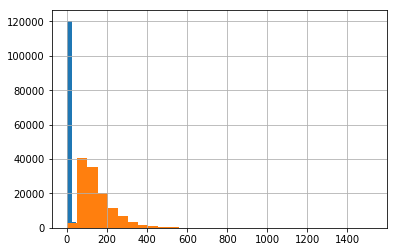

In [31]:
(descriptions.product_description.str.count('\d+') + 1).hist(bins=30)
(descriptions.product_description.str.count('\W')+1).hist(bins=30)




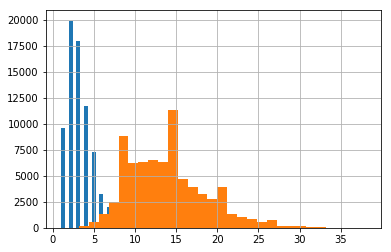

In [32]:
(training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of digits in title
(training_data.product_title.str.count("\\w+") + 1).hist(bins=30)#plot number of digits in title





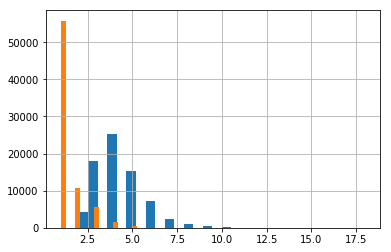

In [33]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search therms
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of digits in search terms







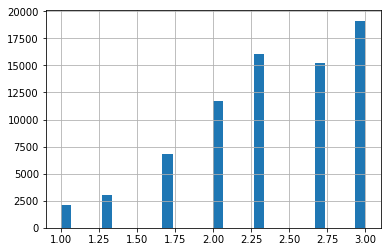

In [34]:
(training_data.relevance ).hist(bins=30)

/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


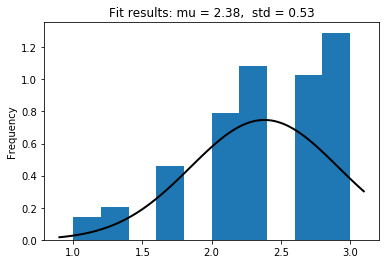

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.relevance.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.relevance)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

## this part has been added

In [17]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, len(x)+1)/n
    return x,y


In [19]:
normal_distr

1.5230320281686132

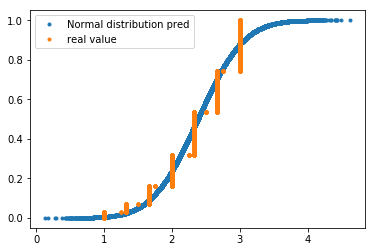

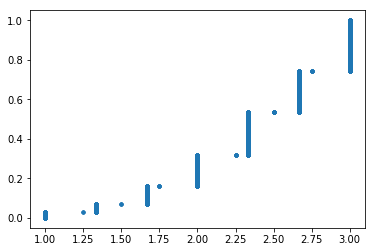

In [39]:
normal_distr = np.random.normal(loc=mu, scale=std, size=len(training_data.relevance))

x_distr, y_distr = ecdf(normal_distr)
x_hyp, y_hyp = ecdf(training_data.relevance)

plt.plot(x_distr, y_distr, marker='.', linestyle='none')
plt.plot(x_hyp, y_hyp, marker='.', linestyle='none')
plt.legend(['Normal distribution pred', 'real value'])
plt.show()

plt.plot(x_hyp, y_hyp, marker='.', linestyle='none')

plt.show()

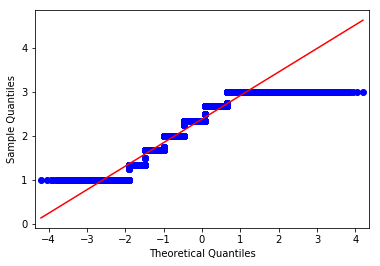

In [41]:
from statsmodels.graphics.gofplots import qqplot
from numpy.random import seed
from matplotlib import pyplot


# generate univariate observations
# q-q plot
qqplot(training_data.relevance, line='s')
pyplot.show()



the conclusion follows that relevancy score doesn't follows the normal distribution skip above

## this section

In [17]:
print('total data has html tags in',descriptions.product_description.str.count('<br$').values.sum())

total data has html tags in 173


In [18]:
descriptions[descriptions.product_description.str.contains("<br")].values.tolist()[:3]

[[100050,
  'Sit back and relax in comfort and style in these Beverly Patio Dining Armchairs with Bare Cushions (2-Pack) from Hampton Bay. Perfect for a deck, porch, patio or sunroom, the chairs are made with a powder-coated, sturdy and durable rust-resistant, steel-reinforced frame with all-weather resin wicker to help withstand outdoor elements. Inspired by vintage styles, they feature a woven multi-brown wicker finish and include bare seat cushions that can be customized with slipcovers through the Choose Your Own Color option.Part of the Choose Your Own Color program, slipcovers for cushions must be purchased separatelyAll-weather resin wicker crafts a versatile piece for indoor and outdoor useFashioned with a multi-brown wicker finish for a vintage aesthetic in your outdoor living areaNo assembly requiredAll components packed in 1 boxCoordinates with other brown wicker items in the Beverly collection (sold separately)2-year limited frame, fabric and weave warrantyPowder-coated ste

In [ ]:
descriptions.product_description.str.contains("Click here to review our return policy for additional information regarding returns").values.sum()

173

In [49]:
training_data[training_data.search_term.str.contains("^\\d+ . \\d+$")].head(10)

,id,product_uid,product_title,search_term,relevance
3377,10452,101800,Kaleen Habitat Bahama Rose Paprika 4 ft. x 6 f...,4 x 6,2.00
3650,11307,101959,Pressure-Treated Timber #2 Southern Yellow Pin...,4 x 6,1.67
3766,11705,102041,Kaleen Habitat Calypso Azure 4 ft. x 6 ft. Ind...,4 x 6,3.00
4513,14166,102472,Safavieh Lyndhurst Sage/Ivory 4 ft. x 6 ft. Ar...,4 x 6,1.33
7247,22691,104370,Wilsonart 48 in. x 96 in. Laminate Sheet in Mo...,48 x 96,2.33
7485,23405,104575,Yosemite Home Decor Undermount Stainless Steel...,23 x 38,2.33
13639,42190,110172,Sigman 20 ft. x 20 ft. Blue Tarp,20 x 20,2.67
15523,47882,112008,Wilsonart 48 in. x 96 in. Laminate Sheet in Su...,48 x 96,3.00
21335,65959,118174,1 in. Depth EZ Flow Heavy Duty (Case of 12),20 x 20,1.67
23618,72613,120571,Honeywell 1 in. Allergen Superior Pleated FPR ...,20 x 20,1.67


In [ ]:
training_data[training_data.product_uid==100030]

,id,product_uid,product_title,search_term,relevance
44,164,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,8 4616809045 9,1.67
45,165,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,shelf bracket,3.00
46,166,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,white 4shelves,1.67


from above the following conclusion follows. 
   - At first there exists fields which has html tags in for __description__ dataset. (maybe and error made by the scrapper) along with _Click here to review our return policy_
   - There is no missing/empty values in any of these datasets 
   - in dataset __description__ field product_description contains more digits than word characters
   - some query in dataset __training__ are too straight, it's hard to guess exactly what user meant in terms of broad  sense
   - some of the search query in dataset __training__ has too specific meaning like 8 4616809045 9	
   - number of diggits appearence in the product title tends to be greater number of characters for dataset __training__ (and the same is true for search query field)
   - the relevancy score is between 1 and 3. Because the density of product whose relevancy score is between 2 and 3 is higher we can conclude that most of search query has been classifield between 2 and 3
   - The histogram of relevancy score doesn't follow standard distribution pattern
   
   
   
In order to continue the analysis we will need the whole datasets
   - description datasets might be joined together to training by the product_uid (the same holds for attribute datasets) then clean the html parts
   
   

## Data cleaning

In [21]:
## let's create first the cleaning functions
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
#     return " ".join([stemmer.stem(word) for word in s.lower().split()])
    return " ".join(map(stemmer.stem, s.lower().split()))

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return sum(int(str2.find(word)>=0) for word in whole_set)


def get_shared_words(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word(*row_data[1:])])



In [22]:
############### cleaning html tags ##################
has_tag_in = descriptions.product_description.str.contains('<br')
descriptions.loc[has_tag_in, 'product_description'] = descriptions.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

Examing the search query in the datasets __training__, there some misspelings for field _search_term_ contains a lot of misspelling (more than 3000). This might be fixed by using Google API 

In [ ]:
import requests
import re
import time
from random import randint

START_SPELL_CHECK="<span class=\"spell\">Showing results for</span>"
END_SPELL_CHECK="<br><span class=\"spell_orig\">Search instead for"
HTML_Codes = (("'", '&#39;'),('"', '&quot;'),('>', '&gt;'),('<', '&lt;'),('&', '&amp;'))

def spell_check(s):
    q = '+'.join(s.split())
    time.sleep(  randint(0,1) ) #relax and don't let google be angry
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        search= content[start:end]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
        search = search[1:]
    else:
        search = s
    return search 

Indeed correcting the misspelings words might help, due to ability of reproducing the result at Kaggle, we won't do spell correction

In [23]:
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")

In [41]:
training_data

,id,product_uid,product_title,search_term,relevance,product_description,search_term_tokens,product_title_tokens,product_description_tokens,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
0,2,100001,simpson strongtie angle,angl bracket,3.00,angles make joints stronger also provide consi...,"[angle, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",4,24,0.200000,0.000000,12,71,0.584761,0.667018
1,3,100001,simpson strongtie angle,l bracket,2.50,angles make joints stronger also provide consi...,"[l, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",3,24,0.000000,0.000000,9,71,0.437595,0.635434
2,9,100002,behr premium textured deckover tugboat wood co...,deck over,3.00,behr premium textured deckover innovative soli...,"[deck, over]","[behr, premium, textured, deckover, 1-gal., #s...","[behr, premium, textured, deckover, is, an, in...",21,62,0.000000,0.000000,9,111,0.783244,0.700815
3,16,100005,delta vero shower faucet trim kit chrome valve...,rain shower head,2.33,update bathroom delta vero singlehandle shower...,"[rain, shower, head]","[delta, vero, 1-handle, shower, only, faucet, ...","[update, your, bathroom, with, the, delta, ver...",15,56,0.066667,0.012346,16,62,0.784465,0.824591
4,17,100005,delta vero shower faucet trim kit chrome valve...,shower onli faucet,2.67,update bathroom delta vero singlehandle shower...,"[shower, only, faucet]","[delta, vero, 1-handle, shower, only, faucet, ...","[update, your, bathroom, with, the, delta, ver...",17,57,0.230769,0.025000,18,62,0.870930,0.892532
5,18,100006,whirlpool cu ft range convection microwave sta...,convect otr,3.00,achieving delicious results almost effortless ...,"[convection, otr]","[whirlpool, 1.9, cu., ft., over, the, range, c...","[achieving, delicious, results, is, almost, ef...",74,75,0.062500,0.003356,11,306,0.760464,0.702093
6,20,100006,whirlpool cu ft range convection microwave sta...,microwav over stove,2.67,achieving delicious results almost effortless ...,"[microwave, over, stove]","[whirlpool, 1.9, cu., ft., over, the, range, c...","[achieving, delicious, results, is, almost, ef...",75,75,0.125000,0.003344,19,306,0.798145,0.766465
7,21,100006,whirlpool cu ft range convection microwave sta...,microwav,3.00,achieving delicious results almost effortless ...,[microwaves],"[whirlpool, 1.9, cu., ft., over, the, range, c...","[achieving, delicious, results, is, almost, ef...",73,74,0.000000,0.000000,8,306,0.536399,0.493355
8,23,100007,lithonia lighting quantum black led emergency ...,emerg light,2.67,quantum adjustable led black emergency lightin...,"[emergency, light]","[lithonia, lighting, quantum, 2-light, black, ...","[the, quantum, adjustable, 2-light, led, black...",12,59,0.100000,0.021978,11,75,0.742676,0.688208
9,27,100009,house fara ft mdf fluted casing,mdf 3/4,3.00,get house fara ft mdf fluted casing add elegan...,"[mdf, 3/4]","[house, of, fara, 3/4, in., x, 3, in., x, 8, f...","[get, the, house, of, fara, 3/4, in., x, 3, in...",19,32,0.166667,0.032258,7,43,0.510292,0.362201


In [ ]:
print("It has blank/empty fields ",training_data.isnull().values.sum())


It has blank/empty fields  0


## Feature Engineering

### Plan
We are going to do the following:
0. Join dataset __training__ with __description__  by  _product uid_ (already done)

2. Create num columns based on text columns
    - count number of words from search query which appears both in product_title and product_description
    - compute edit distnace from search query which appears both in product_title and product_title
    - compute the cosine similarity between search query, product_title and product_description
    - count number of words in the product description
    - create new columns for each pair
    
3. Remove all text columns

As a result we will have vectors of numbers that suites well for the machine learning.

In [53]:
print("has blank/empty values",training_data.isnull().values.any())

has blank/empty values False


In [24]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


def sentence_similarity(columns,stopwords=None):
    sent1, sent2 = columns[0], columns[1]
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def get_jaccard_sim(columns): 
    str1, str2 = columns[0], columns[1]
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def calc_edit_dist(row):
    return edit_distance(*row)

    

In [25]:
################begin testing
## let's create first the cleaning functions
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def str_stemmer_tokens(tokens):
    # split into tokens by white space
#     tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join(map(stemmer.stem, s))

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return sum(int(str2.find(word)>=0) for word in whole_set)


# def str_common_word(str1, str2):
#     return sum(int(str2.find(word)>=0) for word in str1.split())


def str_common_word2(str1, str2):
    part_of_first = set(str1)
    return sum(1 for word in str2 if word in part_of_first)
#     return sum(int(str2.find(word)>=0) for word in str1.split())

def get_shared_words_mut(row_data):
    return np.sum([str_common_word2(*row_data[:-1]), str_common_word2(*row_data[1:])])


def get_shared_words_imut(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word2(*row_data[1:])])
    
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


def sentence_similarity(columns,stopwords=None):
    sent1, sent2 = columns[0], columns[1]
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def get_jaccard_sim(columns): 
    str1, str2 = columns[0], columns[1]
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [26]:
############## apply stemming #####################
#  also .apply(, raw=True) might be a good options
# https://github.com/s-heisler/pycon2017-optimizing-pandas to see why it is done on this way
############## apply stemming #####################



training_data['search_term_tokens'] = training_data.search_term.str.lower().str.split()
training_data['product_title_tokens'] = training_data.product_title.str.lower().str.split()
training_data['product_description_tokens'] = training_data.product_description.str.lower().str.split()

training_data['search_term'] = [str_stemmer_title(_) for _ in training_data.search_term_tokens.values.tolist()]
training_data['product_title'] = [str_stemmer_tokens(_) for _ in training_data.product_title_tokens.values.tolist()]
training_data['product_description'] = [str_stemmer_tokens(_) for _ in training_data.product_description_tokens.values.tolist()]


training_data['shared_words_mut'] = [get_shared_words_mut(columns)
                         for columns in 
                         training_data[['search_term_tokens', 'product_title_tokens', 'product_description_tokens']].values.tolist()
                        ]

training_data['shared_words'] = list(map(get_shared_words_imut, training_data[['search_term','product_description', 'product_title']].values))


training_data['j_dis_sqt'] = [get_jaccard_sim(rows) for rows in training_data[["search_term_tokens","product_title_tokens"]].values]
training_data['j_dis_sqd'] = [get_jaccard_sim(rows) for rows in training_data[["search_term_tokens","product_description_tokens"]].values]

training_data['search_query_length'] = training_data.search_term.str.len()
training_data['number_of_words_in_descr'] = training_data.product_description.str.count("\\w+")


training_data['cos_dis_sqt'] = [ sentence_similarity(rows) for rows in training_data[["search_term","product_title"]].values]
training_data['cos_dis_sqd'] = [sentence_similarity(rows) for rows in training_data[["search_term","product_description"]].values]

## use tensorflow for below since it takes too much time on cpu

In [27]:
# this two lines takeing too long time to execute have to be transl
# training_data["edistance_sprot"] = [edit_distance(word1, word2) for word1, word2 in
#                                     training_data[["search_term","product_title"]].values.tolist()]


# training_data["edistance_sd"] = [edit_distance(word1, word2) for word1, word2 in
#                                     training_data[["search_term","product_description"]].values.tolist()]

In [28]:
# training_data.corr()
training_data.head(3)

,id,product_uid,product_title,search_term,relevance,product_description,search_term_tokens,product_title_tokens,product_description_tokens,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
0,2,100001,simpson strongtie angle,angl bracket,3.0,angles make joints stronger also provide consi...,"[angle, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",4,24,0.2,0.0,12,71,0.584761,0.667018
1,3,100001,simpson strongtie angle,l bracket,2.5,angles make joints stronger also provide consi...,"[l, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",3,24,0.0,0.0,9,71,0.437595,0.635434
2,9,100002,behr premium textured deckover tugboat wood co...,deck over,3.0,behr premium textured deckover innovative soli...,"[deck, over]","[behr, premium, textured, deckover, 1-gal., #s...","[behr, premium, textured, deckover, is, an, in...",21,62,0.0,0.0,9,111,0.783244,0.700815


__test dataset__
we have to have to apply symmetric transformation for both data set, except relevance score field since it is target field. Except we are not allow to take any actions which might lead to overfitting the data

In [29]:
testing_data = pd.merge(testing_data, descriptions, 
                         on="product_uid", how="left")
print("has blank/empty values",testing_data.isnull().values.any())

has blank/empty values False


In [30]:
############## apply stemming for test data #####################
# testing_data['search_term'] = list(map(str_stemmer_title, testing_data['search_term'].values))
# testing_data['product_title'] = list(map(str_stemmer, testing_data['product_title'].values))
# testing_data['product_description'] = list(map(str_stemmer, testing_data['product_description'].values))
testing_data['search_term_tokens'] = testing_data.search_term.str.lower().str.split()
testing_data['product_title_tokens'] = testing_data.product_title.str.lower().str.split()
testing_data['product_description_tokens'] = testing_data.product_description.str.lower().str.split()

testing_data['search_term'] = [str_stemmer_title(_) for _ in testing_data.search_term_tokens.values.tolist()]
testing_data['product_title'] = [str_stemmer_tokens(_) for _ in testing_data.product_title_tokens.values.tolist()]
testing_data['product_description'] = [str_stemmer_tokens(_) for _ in testing_data.product_description_tokens.values.tolist()]

############## end stemming #####################

In [31]:
############## building custome feature for test data, let's build a few of them before compare which one is the best ###########
# testing_data['shared_words'] = list(map(get_shared_words, testing_data[['search_term','product_description', 'product_title']].values))
# testing_data["edistance_sprot"] = list(map(calc_edit_dist, testing_data[["search_term","product_title"]].values))
# testing_data["edistance_sd"] = list(map(calc_edit_dist, testing_data[["search_term","product_description"]].values))


# testing_data['cos_dis_sqt'] = list(map(sentence_similarity ,testing_data[["search_term","product_title"]].values))
# testing_data['cos_dis_sqd'] = list(map(sentence_similarity, testing_data[["search_term","product_description"]].values))



# testing_data['j_dis_sqt'] = list(map(get_jaccard_sim, testing_data[["search_term","product_title"]].values))
# testing_data['j_dis_sqd'] = list(map(get_jaccard_sim, testing_data[["search_term","product_description"]].values))

# testing_data['j_dis_sqt'] = list(map(get_jaccard_sim, testing_data[["search_term","product_title"]].values))
# testing_data['j_dis_sqd'] = list(map(get_jaccard_sim, testing_data[["search_term","product_description"]].values))

# testing_data['search_query_length'] = testing_data.search_term.str.len()
# testing_data['number_of_words_in_descr'] = testing_data.product_description.str.count("\\w+")

testing_data['shared_words_mut'] = [get_shared_words_mut(columns)
                         for columns in 
                         testing_data[['search_term_tokens', 'product_title_tokens', 'product_description_tokens']].values.tolist()
                        ]

testing_data['shared_words'] = list(map(get_shared_words_imut, testing_data[['search_term','product_description', 'product_title']].values))


testing_data['j_dis_sqt'] = [get_jaccard_sim(rows) for rows in testing_data[["search_term_tokens","product_title_tokens"]].values]
testing_data['j_dis_sqd'] = [get_jaccard_sim(rows) for rows in testing_data[["search_term_tokens","product_description_tokens"]].values]

testing_data['search_query_length'] = testing_data.search_term.str.len()
testing_data['number_of_words_in_descr'] = testing_data.product_description.str.count("\\w+")


testing_data['cos_dis_sqt'] = [ sentence_similarity(rows) for rows in testing_data[["search_term","product_title"]].values]
testing_data['cos_dis_sqd'] = [sentence_similarity(rows) for rows in testing_data[["search_term","product_description"]].values]




In [ ]:
#this two lines taking too long to execute

# testing_data["edistance_sprot"] = [edit_distance(word1, word2) for word1, word2 in
#                                     testing_data[["search_term","product_title"]].values.tolist()]


# testing_data["edistance_sd"] = [edit_distance(word1, word2) for word1, word2 in
#                                     testing_data[["search_term","product_description"]].values.tolist()]


In [60]:
testing_data.corr()

,id,product_uid,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
id,1.000000,0.984240,-0.050582,0.034211,0.122488,0.073183,0.064054,-0.090713,0.078321,0.028857
product_uid,0.984240,1.000000,-0.052677,0.029510,0.116859,0.065450,0.051154,-0.086828,0.068873,0.020203
shared_words_mut,-0.050582,-0.052677,1.000000,0.488065,0.034358,0.019210,0.162048,0.608730,0.119524,0.142095
shared_words,0.034211,0.029510,0.488065,1.000000,-0.086580,-0.044080,0.219032,0.347420,0.153782,0.162426
j_dis_sqt,0.122488,0.116859,0.034358,-0.086580,1.000000,0.507038,0.295854,-0.035548,0.422333,0.260100
j_dis_sqd,0.073183,0.065450,0.019210,-0.044080,0.507038,1.000000,0.332012,-0.295673,0.322405,0.311699
search_query_length,0.064054,0.051154,0.162048,0.219032,0.295854,0.332012,1.000000,0.102122,0.542840,0.628685
number_of_words_in_descr,-0.090713,-0.086828,0.608730,0.347420,-0.035548,-0.295673,0.102122,1.000000,0.053292,0.068046
cos_dis_sqt,0.078321,0.068873,0.119524,0.153782,0.422333,0.322405,0.542840,0.053292,1.000000,0.813355
cos_dis_sqd,0.028857,0.020203,0.142095,0.162426,0.260100,0.311699,0.628685,0.068046,0.813355,1.000000


In [ ]:
testing_data.corr()

,id,product_uid,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
id,1.000000,0.984240,-0.050582,0.034211,0.122488,0.073183,0.064054,-0.090713,0.078321,0.028857
product_uid,0.984240,1.000000,-0.052677,0.029510,0.116859,0.065450,0.051154,-0.086828,0.068873,0.020203
shared_words_mut,-0.050582,-0.052677,1.000000,0.488065,0.034358,0.019210,0.162048,0.608730,0.119524,0.142095
shared_words,0.034211,0.029510,0.488065,1.000000,-0.086580,-0.044080,0.219032,0.347420,0.153782,0.162426
j_dis_sqt,0.122488,0.116859,0.034358,-0.086580,1.000000,0.507038,0.295854,-0.035548,0.422333,0.260100
j_dis_sqd,0.073183,0.065450,0.019210,-0.044080,0.507038,1.000000,0.332012,-0.295673,0.322405,0.311699
search_query_length,0.064054,0.051154,0.162048,0.219032,0.295854,0.332012,1.000000,0.102122,0.542840,0.628685
number_of_words_in_descr,-0.090713,-0.086828,0.608730,0.347420,-0.035548,-0.295673,0.102122,1.000000,0.053292,0.068046
cos_dis_sqt,0.078321,0.068873,0.119524,0.153782,0.422333,0.322405,0.542840,0.053292,1.000000,0.813355
cos_dis_sqd,0.028857,0.020203,0.142095,0.162426,0.260100,0.311699,0.628685,0.068046,0.813355,1.000000


In [ ]:
training_data.describe()

,id,product_uid,relevance,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
count,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634,16.632724,55.249976,0.133894,0.018396,17.606734,84.404337,0.750231,0.725384
std,64016.573650,30770.774864,0.533984,10.675546,19.058694,0.104349,0.015997,7.231461,48.720113,0.135662,0.128294
min,2.000000,100001.000000,1.000000,0.000000,6.000000,0.000000,0.000000,2.000000,13.000000,0.000000,0.000000
25%,57163.500000,115128.500000,2.000000,9.000000,41.000000,0.066667,0.007874,12.000000,50.000000,0.687111,0.666166
50%,113228.000000,137334.000000,2.330000,14.000000,53.000000,0.117647,0.015625,17.000000,72.000000,0.779008,0.751104
75%,168275.500000,166883.500000,3.000000,21.000000,68.000000,0.190476,0.025641,22.000000,105.000000,0.845656,0.815402
max,221473.000000,206650.000000,3.000000,164.000000,125.000000,1.000000,0.190476,59.000000,562.000000,1.000000,0.971390


In [ ]:
testing_data.describe()

,id,product_uid,shared_words_mut,shared_words,j_dis_sqt,j_dis_sqd,search_query_length,number_of_words_in_descr,cos_dis_sqt,cos_dis_sqd
count,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000
mean,123932.839741,149713.170445,16.611729,54.856743,0.132491,0.017771,16.499079,84.652097,0.740166,0.712677
std,71518.389174,37270.476881,10.767395,19.097372,0.105038,0.015581,7.099329,48.373132,0.138944,0.132597
min,1.000000,100001.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,61669.000000,116665.000000,9.000000,41.000000,0.066667,0.007246,11.000000,50.000000,0.672976,0.649393
50%,124004.000000,142445.000000,14.000000,53.000000,0.117647,0.014925,16.000000,72.000000,0.769058,0.738709
75%,187036.000000,179444.000000,21.000000,67.000000,0.187500,0.025316,21.000000,106.000000,0.838512,0.806693
max,240760.000000,224428.000000,162.000000,128.000000,1.000000,0.200000,60.000000,553.000000,1.000000,0.974223


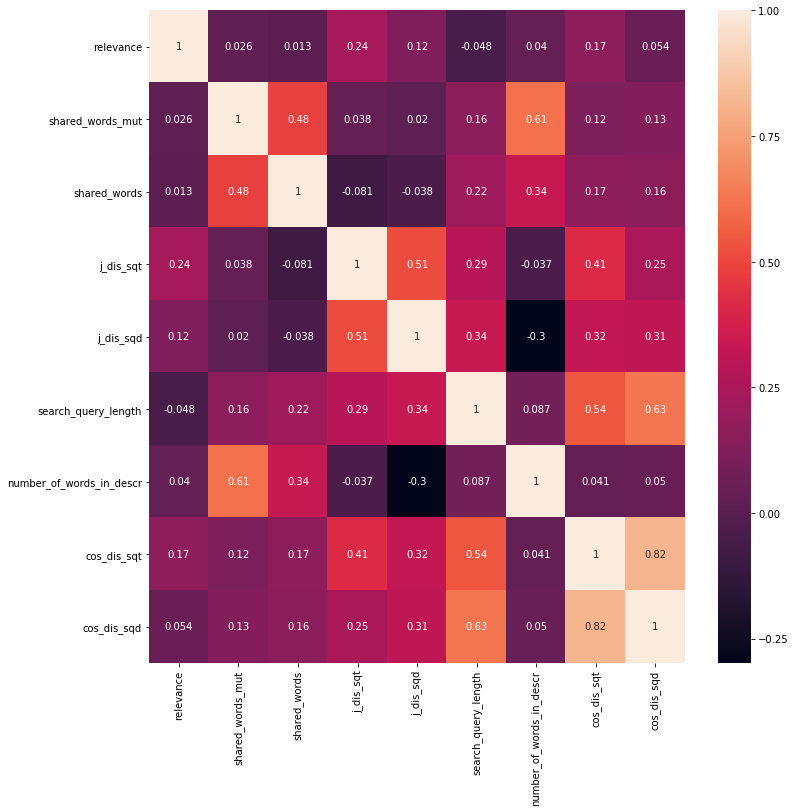

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = training_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = testing_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

let's check wheather this is follows Gaussian distribution or not. Indeed it doesn't follow Gaussian distribution, that follows from Shapiro test

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


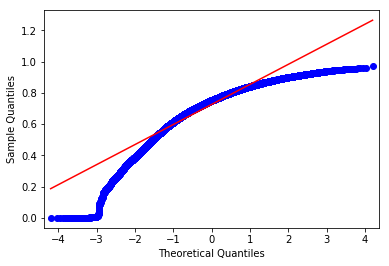

Statistics=0.909, p=0.000


/Users/iurii/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro


from matplotlib import pyplot
qqplot(training_data.cos_dis_sqd, line='s')
pyplot.show()

stat, p = shapiro(training_data.cos_dis_sqd)
print('Statistics=%.3f, p=%.3f' % (stat, p))

let's try to find out if wheather it follows normal distribution or not, by doing a few others test

In [ ]:
from scipy.stats import normaltest

stat, p = normaltest(training_data.cos_dis_sqd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
from scipy.stats import anderson

result = anderson(training_data.cos_dis_sqd)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
from matplotlib import pyplot
qqplot(training_data.cos_dis_sqt, line='s')
pyplot.show()

stat, p = shapiro(training_data.cos_dis_sqt)
print('Statistics=%.3f, p=%.3f' % (stat, p))

From the below histogram we can conclude that the sum of shared words between search_query product_title, and product description follows the standard distribution.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro


from matplotlib import pyplot
qqplot(training_data.shared_words, line='s')
pyplot.show()

stat, p = shapiro(training_data.shared_words)
print('Statistics=%.3f, p=%.3f' % (stat, p))

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from scipy.stats import norm  

# training_data.edistance_sprot.plot(kind='hist', normed=True)

# mu, std = norm.fit(training_data.edistance_sprot)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)

# plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

let's examing if the same behaviour can be spotted on __testing__ dataset

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from scipy.stats import norm  

# testing_data.edistance_sprot.plot(kind='hist', normed=True)

# mu, std = norm.fit(testing_data.edistance_sprot)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)

# plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
training_data.shape

np.max([np.log(74067) / np.log(x) for x in training_data.search_query_length])


In [ ]:
sns.pairplot(training_data)

In [ ]:
# sns.pairplot(testing_dataing_data)

# 3. Let's start machine learning
first of all let's create training and test data sets


We are going to apply the following models:
1. RandomForestRegressor
2. LinearRegression
4. GradientBoostingRegressor 
5. BaggingRegressor
6. Chain model withing pipeline
7. XGBoost
8. CatBoost
9. Naive Baies
10. PolynomialFeatures for all previous algorithms


### Plan
We are going to do the following:
0. Define pipeline
1. drop non numeric columns because these information has been already transformed to numberic
2. Apply the model which has been mentioned above within pipeline mode and outside pipeline
3. Train models and compare their result on __test__ dataset
4. write a summary about it





In [33]:
df_training = training_data.drop(['product_title','search_term','product_description', 'product_title_tokens', 'product_description_tokens','product_title_tokens','search_term_tokens'],axis=1)

y_train = df_training['relevance'].values
X_train = df_training.drop(['id','relevance'],axis=1).values

In [34]:
# X_test = testing_data.drop(['id','product_title','search_term','product_description'],axis=1).values
X_test = testing_data.drop(['id','product_title','search_term','product_description', 'product_title_tokens', 'product_description_tokens','product_title_tokens','search_term_tokens'],axis=1).values

id_test = testing_data['id']

In [37]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = {
                'loss' : ['ls'],
                'n_estimators' : [3], 
                'max_depth' : [9],
                'max_features' : ['auto'] 
             }

gbr = GradientBoostingRegressor()


top_models = {"RandomForestRegressor":RandomForestRegressor(n_estimators = 12, n_jobs = -1, random_state = 17, verbose = 1),
              "LinearRegression": LinearRegression(n_jobs = -1),
              "GradientBoostingRegressor": GradientBoostingRegressor(),
              "GridSearchCV":sklearn.model_selection.GridSearchCV(estimator = gbr, n_jobs = -1, param_grid = param_grid)
             }

              

In [ ]:
# borrowed the idea from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
import logging
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor


models_top = []
models_labels = []
seed = 7

# logging.setLevel(logging.DEBUG)


for name, model in top_models.items():
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs = -1)
    models_labels.append(name)
    models_top.append(cv_results)
#     models_dict[name] = cv_results
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

DEBUG:root:This will get logged


RandomForestRegressor: 0.039485 (0.040817)
LinearRegression: 0.094721 (0.025377)
GradientBoostingRegressor: 0.122098 (0.020536)


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos


GridSearchCV: 0.035334 (0.028511)


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


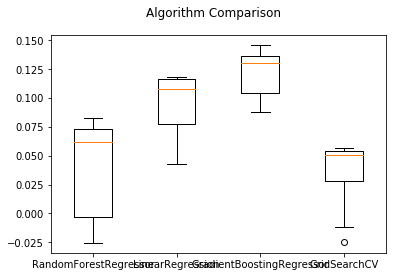

In [40]:

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(models_top)
ax.set_xticklabels(models_labels)
plt.show()

## 3.4 BaggingRegressor based on  RandomForestRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
rf = RandomForestRegressor(max_depth = 20, max_features =  'sqrt', n_estimators = 3)
clf = BaggingRegressor(rf, n_estimators=3, max_samples=0.1, random_state=25)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

In [ ]:
cat

## 3.5 Chain model withing pipeline


In [ ]:
# define models which will be chained togher in a bigger model, which aims to predict the relevancy score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

#define standard scaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaled_train_data = scaler.transform(X_train)
scaled_test_data = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)


pipeline = Pipeline(steps = [('scaling', scaler), ('baggingregressor', clf)])
#end pipeline 
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


## 3.6 Naive Bayes

In [ ]:
from sklearn.linear_model import BayesianRidge

gnb = BayesianRidge()
param_grid = {}
model_nb = sklearn.model_selection.GridSearchCV(estimator = gnb, param_grid = param_grid, n_jobs = -1)
model_nb.fit(X_train, y_train)

y_pred = model_nb.predict(X_test)
# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

## 3.7 XGBoost

In [86]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
param_grid = {'max_depth':[5, 6], 
              'n_estimators': [130, 150, 170], 
              'learning_rate' : [0.1]}
model_xgb = sklearn.model_selection.GridSearchCV(estimator = xgb, param_grid = param_grid, n_jobs = -1)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
params = [.1, .3, .5, .7, .9, .99,1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error");


## resouce for inspiration
https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

# Results



|Regressor|Train|Kaggle
|:----------------------|----------|----------|
|CatBoostRegressor|-|-|
|XGBRegressor|-|-|
|GradientBoostingRegressor|-|-|
|PolynomialFeatures on GradientBoostingRegressor|-|-|
|PolynomialFeatures on XGBRegressor|-|-|
|PolynomialFeatures on LinearRegression|-|-|
|PolynomialFeatures on BaggingRegressor on RandomForestRegressor|-|-|
|BaggingRegressor on RandomForestRegressor|0.53480|0.53427|
|Chaining toghether using Pipeline|0.53063|0.53100|
|BayesianRidge|-|-|
|LinearRegression|-|-|
|PolynomialFeatures on BayesianRidge|-|-|
|RandomForestRegressor|0.59063|0.58869|
